In [ ]:
!pip install geopandas
!pip install rasterio
!pip install owslib
!pip install folium
!pip install psycopg2
!pip install shapely
!pip install matplotlib
!pip install geopandas rasterio folium owslib matplotlib urllib3 requests branca --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 60.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.1/240.1 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 50.4 MB/s eta 0:00:00
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.10.0
    Uninstalling matplotlib-3.10.0:
      Successfully uninstalled matplotlib-3.10.0


In [ ]:
# Importações
import geopandas as gpd
import rasterio
from rasterio.mask import mask
from owslib.wfs import WebFeatureService
from owslib.wms import WebMapService
import folium
from folium import plugins
from branca.colormap import LinearColormap
from shapely.geometry import Point
import matplotlib.pyplot as plt
from rasterio.plot import show
import requests
import numpy as np


In [ ]:
# Função auxiliar para salvar mapas Folium
def save_map(m, filename):
    m.save(filename)
    print(f"Mapa salvo como: {filename}")

# 1. Inserir a coordenada
lat, lon = -20.150376, -55.206029  # Coordenada atualizada
ponto = Point(lon, lat)
print(f"Coordenada inserida: ({lat}, {lon})")

m1 = folium.Map(location=[lat, lon], zoom_start=12)
folium.Marker([lat, lon], popup="Coordenada", icon=folium.Icon(color="red")).add_to(m1)
save_map(m1, "mapa_etapa1_coordenada.html")

Coordenada inserida: (-20.150376, -55.206029)
Mapa salvo como: mapa_etapa1_coordenada.html


In [ ]:
# 2. Localizar o estado (usando WFS do IBGE)
print("Etapa 2.1: Conectando ao WFS do IBGE...")
wfs_url = "https://geoservicos.ibge.gov.br/geoserver/CGMAT/wfs"
wfs = WebFeatureService(wfs_url, version='1.1.0')
layer = "CGMAT:pbqg22_02_Estado_LimUF"

m2_1 = folium.Map(location=[lat, lon], zoom_start=12)
folium.Marker([lat, lon], popup="Coordenada", icon=folium.Icon(color="red")).add_to(m2_1)
save_map(m2_1, "mapa_etapa2_1_conexao_wfs.html")

print("Etapa 2.2: Consultando os limites dos estados no WFS...")
bbox = (lon-0.1, lat-0.1, lon+0.1, lat+0.1)
response = wfs.getfeature(typename=layer, bbox=bbox, outputFormat='json')
estados_gdf = gpd.read_file(response)

print("Colunas disponíveis no WFS:", estados_gdf.columns.tolist())
estado = estados_gdf[estados_gdf.contains(ponto)].iloc[0]
nm_uf = estado['nm_uf']  # Usando 'nm_uf'
print(f"Estado encontrado: {nm_uf}")

m2_2 = folium.Map(location=[lat, lon], zoom_start=8)
folium.GeoJson(
    estado.geometry.__geo_interface__,
    name=f"Estado {nm_uf}",
    style_function=lambda x: {"color": "blue", "weight": 1, "fillOpacity": 0}  # Vazado, apenas perímetro
).add_to(m2_2)
folium.Marker([lat, lon], popup="Coordenada", icon=folium.Icon(color="red")).add_to(m2_2)
save_map(m2_2, "mapa_etapa2_2_estado_wfs.html")

Etapa 2.1: Conectando ao WFS do IBGE...
Mapa salvo como: mapa_etapa2_1_conexao_wfs.html
Etapa 2.2: Consultando os limites dos estados no WFS...
Colunas disponíveis no WFS: ['id', 'cd_recorte', 'quadro', 'cd_uf', 'nm_uf', 'geometry']
Estado encontrado: Mato Grosso do Sul
Mapa salvo como: mapa_etapa2_2_estado_wfs.html


In [ ]:
# 3. Consultar o CAR a partir de um arquivo GeoJSON local
print("Etapa 3: Carregando o CAR a partir de um arquivo GeoJSON local...")
from google.colab import files
uploaded = files.upload()  # Faça upload do arquivo GeoJSON do CAR
geojson_file = list(uploaded.keys())[0]

try:
    imovel_gdf = gpd.read_file(geojson_file)
    print(f"Arquivo GeoJSON carregado: {geojson_file}")
    imovel = imovel_gdf[imovel_gdf.contains(ponto)].iloc[0]
    perimetro = imovel.geometry
    cod_imovel = imovel['cod_imovel'] if 'cod_imovel' in imovel else "Não disponível"  # Extrair cod_imovel
    print(f"Imóvel encontrado - Código: {cod_imovel}")

    m3 = folium.Map(location=[lat, lon], zoom_start=12)
    folium.GeoJson(
        perimetro.__geo_interface__,
        name="Imóvel",
        style_function=lambda x: {"color": "white", "weight": 2, "fillOpacity": 0}  # Apenas contorno branco
    ).add_to(m3)
    folium.Marker([lat, lon], popup=f"Coordenada\nCódigo Imóvel: {cod_imovel}", icon=folium.Icon(color="red")).add_to(m3)
    save_map(m3, "mapa_etapa3_imovel.html")
except Exception as e:
    print(f"Erro ao processar o arquivo GeoJSON do CAR: {e}")

Etapa 3: Carregando o CAR a partir de um arquivo GeoJSON local...


Saving car_ms.geojson to car_ms.geojson
Arquivo GeoJSON carregado: car_ms.geojson
Imóvel encontrado - Código: MS-5001102-B64325988283479FADAEC7E54229713F
Mapa salvo como: mapa_etapa3_imovel.html


Etapa 4: Carregando o arquivo PRODES...


Saving corte.tif to corte.tif
Valor máximo de desmatamento: 255
Transform: | 0.00, 0.00,-55.21|
| 0.00,-0.00,-20.14|
| 0.00, 0.00, 1.00|
CRS: EPSG:4674
Valores únicos no raster: [  0  15 100 255]


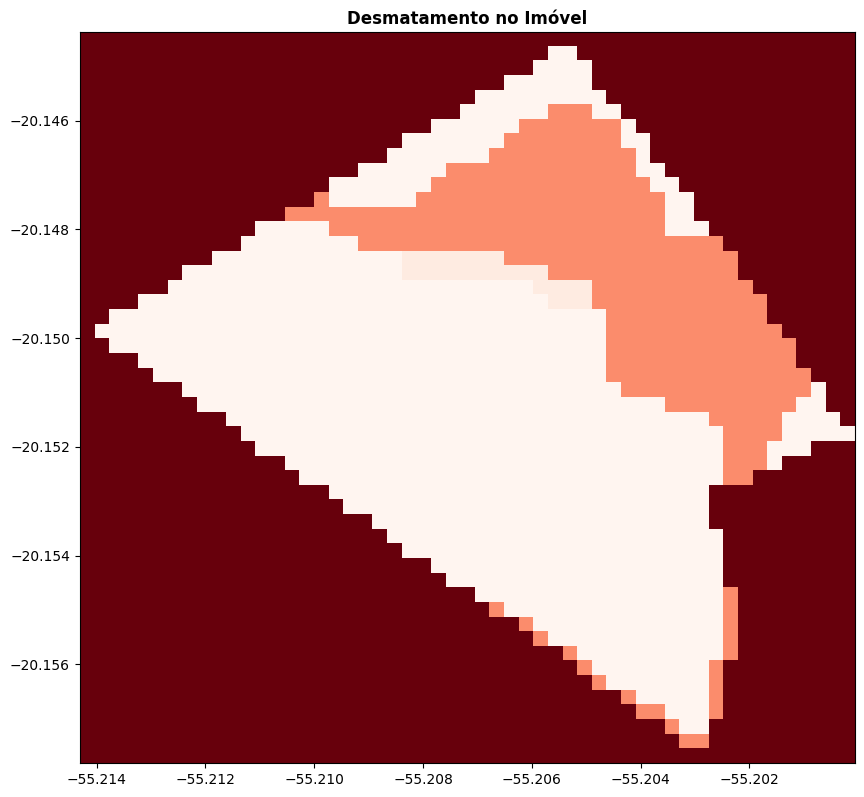

Imagem de desmatamento salva como: etapa4_desmatamento.png


In [ ]:
# 4. Analisar desmatamento no arquivo PRODES
print("Etapa 4: Carregando o arquivo PRODES...")
uploaded = files.upload()  # Faça upload do "prodes_desmatamento.tif"
tiff_file = list(uploaded.keys())[0]

with rasterio.open(tiff_file) as src:
    desmatamento_data, transform = mask(src, [perimetro], crop=True)
    desmatamento_values = desmatamento_data[0]
    if desmatamento_values.max() > 0:
        print(f"Valor máximo de desmatamento: {desmatamento_values.max()}")
    else:
        print("Nenhum desmatamento detectado.")

    # Depuração: Exibir transform, CRS e valores únicos
    print(f"Transform: {transform}")
    print(f"CRS: {src.crs}")
    print(f"Valores únicos no raster: {np.unique(desmatamento_values)}")

plt.figure(figsize=(10, 10))
show(desmatamento_data, transform=transform, cmap="Reds", title="Desmatamento no Imóvel")
plt.plot([lon], [lat], "ro", label="Coordenada")
plt.legend()
plt.savefig("etapa4_desmatamento.png")
plt.close()
print("Imagem de desmatamento salva como: etapa4_desmatamento.png")

In [ ]:
# 5. Gerar o mapa final com todas as camadas e legenda
print("Etapa 5: Gerando o mapa final com todas as camadas e legenda...")
# Usar fundo de imagens de satélite como padrão (Esri World Imagery)
m5 = folium.Map(
    location=[lat, lon],
    zoom_start=12,
    tiles='https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
    attr='Esri World Imagery'
)
# Adicionar OpenStreetMap como camada alternativa
folium.TileLayer('openstreetmap', name='OpenStreetMap').add_to(m5)

# Adicionar a coordenada (Etapa 1) com pop-up do cod_imovel
folium.Marker([lat, lon], popup=f"Coordenada\nCódigo Imóvel: {cod_imovel}", icon=folium.Icon(color="red")).add_to(m5)

# Adicionar o estado (Etapa 2) com apenas contorno
folium.GeoJson(
    estado.geometry.__geo_interface__,
    name=f"Estado {nm_uf}",
    style_function=lambda x: {"color": "blue", "weight": 1, "fillOpacity": 0}  # Vazado, apenas perímetro
).add_to(m5)

# Adicionar o imóvel (Etapa 3) com apenas contorno branco
folium.GeoJson(
    perimetro.__geo_interface__,
    name="Imóvel",
    style_function=lambda x: {"color": "white", "weight": 2, "fillOpacity": 0}  # Apenas contorno branco
).add_to(m5)

# Função personalizada de colormap para o PRODES
def prodes_colormap(value):
    if 0 <= value <= 23:
        # Escala de amarelo (#FFFF00) a vermelho (#FF0000)
        scale = (value - 0) / (23 - 0)
        r = int(255 * scale)
        g = int(255 * (1 - scale))
        b = 0
        return (r / 255, g / 255, b / 255, 0.5)  # Transparência de 50%
    elif 50 <= value <= 63:
        # Escala de rosa (#FF69B4) a roxo (#800080)
        scale = (value - 50) / (63 - 50)
        r = int(255 - (127 * scale))
        g = int(105 - (57 * scale))
        b = int(180 * scale)
        return (r / 255, g / 255, b / 255, 0.5)  # Transparência de 50%
    elif value == 100:
        return (0, 0.5, 0, 0.5)  # Verde escuro
    elif value == 101:
        return (0.65, 0.16, 0.16, 0.5)  # Marrom (não floresta)
    elif value == 91:
        return (0, 0.75, 1, 0.5)  # Azul claro (hidrografia)
    elif value == 99:
        return (1, 1, 1, 0.5)  # Branco (nuvem)
    else:
        return (0, 0, 0, 0)  # Totalmente transparente para outros valores

# Adicionar o desmatamento (Etapa 4) com simbologia personalizada
if desmatamento_values.max() > 0:
    from rasterio.features import bounds
    bbox = bounds(perimetro)
    folium.raster_layers.ImageOverlay(
        image=desmatamento_data[0],
        bounds=[[bbox[1], bbox[0]], [bbox[3], bbox[2]]],
        opacity=0.5,
        colormap=prodes_colormap,
        name="Desmatamento PRODES"
    ).add_to(m5)

    # Calcular área desmatada por ano
    def get_year(value):
        if 0 <= value <= 23:
            return 2000 + value
        elif 50 <= value <= 63:
            return 2010 + (value - 50)
        return None

    # Calcular área do pixel (converter de graus para metros)
    pixel_width_deg = abs(transform[0])  # Largura do pixel em graus
    pixel_height_deg = abs(transform[4])  # Altura do pixel em graus
    lat_center = (bbox[1] + bbox[3]) / 2  # Latitude média da área mascarada

    # Converter graus para metros usando a latitude média
    meters_per_degree_lat = 111320  # Aproximadamente 111,320 metros por grau de latitude
    meters_per_degree_lon = 111320 * np.cos(np.radians(lat_center))  # Ajuste por latitude
    pixel_width_m = pixel_width_deg * meters_per_degree_lon  # Largura em metros
    pixel_height_m = pixel_height_deg * meters_per_degree_lat  # Altura em metros
    pixel_area_m2 = pixel_width_m * pixel_height_m  # Área do pixel em m²

    print(f"Pixel width (deg): {pixel_width_deg}, Pixel height (deg): {pixel_height_deg}")
    print(f"Latitude média: {lat_center}, Meters per degree lon: {meters_per_degree_lon}, Meters per degree lat: {meters_per_degree_lat}")
    print(f"Pixel width (m): {pixel_width_m}, Pixel height (m): {pixel_height_m}")
    print(f"Pixel area (m²): {pixel_area_m2}, CRS: {src.crs}")

    # Contar pixels e calcular área
    desmatamento_areas = {}
    for value in np.unique(desmatamento_values):
        year = get_year(value)
        if year is not None:
            pixel_count = np.sum(desmatamento_values == value)
            print(f"Ano: {year}, Pixels contados: {pixel_count}")
            area_ha = (pixel_count * pixel_area_m2) / 10000  # Converter para hectares
            print(f"Área calculada para {year}: {area_ha:.2f} ha")
            if area_ha >= 0:  # Incluir mesmo que zero para depuração
                desmatamento_areas[year] = area_ha

    # Criar tabela HTML com depuração
    print(f"Conteúdo de desmatamento_areas: {desmatamento_areas}")
    if desmatamento_areas:
        table_html = "<div style='position: fixed; top: 50px; left: 50px; z-index: 1000; background-color: white; padding: 10px; border: 2px solid grey;'><b>Área Desmatada por Ano (ha)</b><table border='1'><tr><th>Ano</th><th>Área (ha)</th></tr>"
        for year, area in sorted(desmatamento_areas.items()):
            table_html += f"<tr><td>{year}</td><td>{area:.2f}</td></tr>"
        table_html += "</table></div>"
        m5.get_root().html.add_child(folium.Element(table_html))
    else:
        print("Nenhum desmatamento encontrado nos intervalos 0-23 ou 50-63 ou áreas calculadas são inválidas.")

# Criar a legenda com anos
legend_colors = {
    0: "#FFFF00", 23: "#FF0000",  # Amarelo a vermelho
    50: "#FF69B4", 63: "#800080"   # Rosa a roxo
}

# Mapear valores de pixel para anos
year_labels_1 = [2000 + i for i in range(24)]  # 2000 a 2023
year_labels_2 = [2010 + (i - 50) for i in range(50, 64)]  # 2010 a 2023

colormap = LinearColormap(
    colors=[legend_colors[0], legend_colors[23]],
    vmin=0, vmax=23,
    caption="Desmatamento (2000-2023)",
    index=[0, 23],  # Apenas os extremos
    tick_labels=year_labels_1  # Anos de 2000 a 2023
).to_step(n=24)
colormap.add_to(m5)

colormap2 = LinearColormap(
    colors=[legend_colors[50], legend_colors[63]],
    vmin=50, vmax=63,
    caption="Desmatamento (2010-2023)",
    index=[50, 63],  # Apenas os extremos
    tick_labels=year_labels_2  # Anos de 2010 a 2023
).to_step(n=14)
colormap2.add_to(m5)

html_legend = """
<div style="position: fixed; bottom: 50px; left: 50px; z-index: 1000; background-color: white; padding: 10px; border: 2px solid grey;">
    <p><b>Legenda PRODES</b></p>
    <p><span style='background:#008000; display:inline-block; width:20px; height:20px; margin-right:5px;'></span> Vegetação (100)</p>
    <p><span style='background:#A52A2A; display:inline-block; width:20px; height:20px; margin-right:5px;'></span> Não floresta (101)</p>
    <p><span style='background:#00BFFF; display:inline-block; width:20px; height:20px; margin-right:5px;'></span> Hidrografia (91)</p>
    <p><span style='background:#FFFFFF; display:inline-block; width:20px; height:20px; margin-right:5px; border:1px solid black;'></span> Nuvem (99)</p>
    <p><span style='background:#808080; display:inline-block; width:20px; height:20px; margin-right:5px;'></span> Outros</p>
</div>
"""
m5.get_root().html.add_child(folium.Element(html_legend))

# Adicionar controle de camadas
folium.LayerControl().add_to(m5)

# Salvar o mapa final
save_map(m5, "mapa_etapa5_final_completo.html")

Etapa 5: Gerando o mapa final com todas as camadas e legenda...
Pixel width (deg): 0.0002688999999999989, Pixel height (deg): 0.00026890000000000144
Latitude média: -20.151167469999997, Meters per degree lon: 104505.766115495, Meters per degree lat: 111320
Pixel width (m): 28.101600508456492, Pixel height (m): 29.93394800000016
Pixel area (m²): 841.1918483369147, CRS: EPSG:4674
Ano: 2000, Pixels contados: 828
Área calculada para 2000: 69.65 ha
Ano: 2015, Pixels contados: 24
Área calculada para 2015: 2.02 ha
Conteúdo de desmatamento_areas: {2000: 69.65068504229653, 2015: 2.0188604360085955}
Mapa salvo como: mapa_etapa5_final_completo.html
